# Code for generating 

a) Waveform without lensing -CHECK

b) Lensed waveform with change to inclination/phase of coalescence (1 image)

c) Lensed waveform with doppler shift

d) Lensed waveform (vanilla) without doppler shift or changes to the inclination/phase of coalescence

e) Lensed waveform with everything

# a) Waveform without lensing

In [3]:
# Import pycbc waveform and beam pattern functions
from pycbc import waveform, psd
from pycbc.detector import Detector, get_available_detectors
import pylab as plt
import numpy as np
import scienceplots
plt.style.use(['science'])
# Larger default frame size for figures
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

Time domain (without whitening)

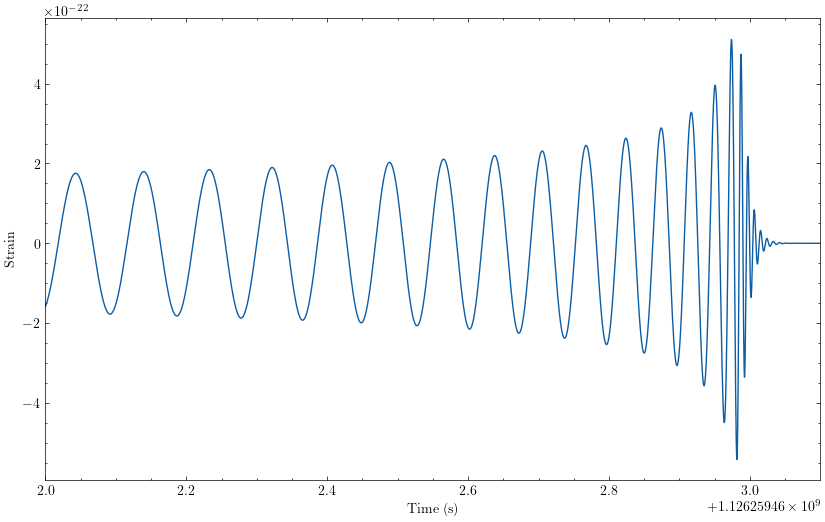

In [4]:
# Plot waveform in time domain
hp, hc = waveform.get_td_waveform(approximant="SEOBNRv4_opt", mass1=80, mass2=80, delta_t=1.0/4096, f_lower=10, distance=2000)
# Set the hp and hc start time to the GPS time
t_gps = 1126259462.0
hp.start_time = hc.start_time = t_gps
# Compute beam pattern functions for a given detector
ifo = "L1"
detector = Detector(ifo)
right_ascension = 1.7
declination = 1.7
polarization = 0.7
# Compute the plus and cross polarizations
fp, fc = detector.antenna_pattern(right_ascension, declination, polarization, t_gps)
h = fp * hp + fc * hc
# Plot the waveform
plt.plot(h.sample_times, h)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(t_gps, t_gps + 1.1)
plt.show()

Time domain with whitening

/home/user/miniforge3/lib/python3.10/site-packages/pycbc/types/array.py:383: RuntimeWarning: divide by zero encountered in divide
  return self._data / other
/home/user/miniforge3/lib/python3.10/site-packages/pycbc/types/array.py:383: RuntimeWarning: invalid value encountered in divide
  return self._data / other


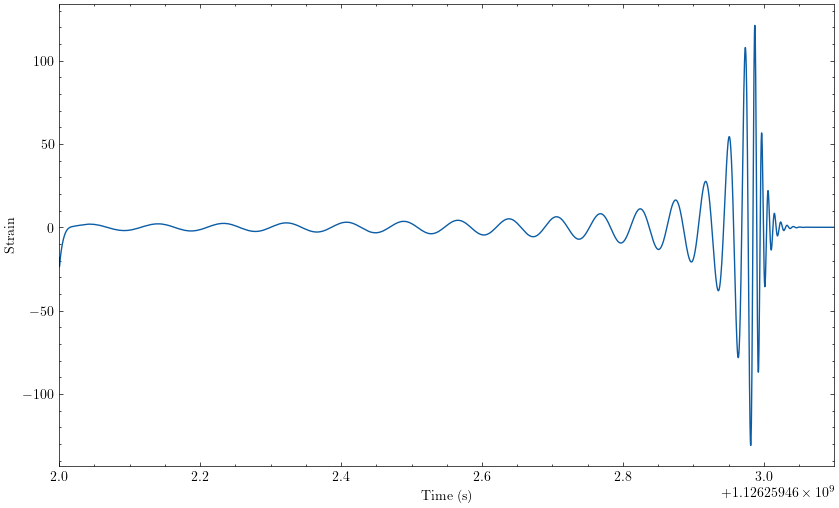

In [5]:
# Transform the waveform to the frequency domain first and then divide out by the PSD
h_frequency = h.to_frequencyseries()
frequencies = h_frequency.sample_frequencies
# Compute the ASD for the detector
# length = int(4096 / 2) + 1
# delta_f = 1.0 / 16
# low_freq_cutoff = 30
length = len(frequencies)
delta_f = frequencies[1] - frequencies[0]
low_freq_cutoff = frequencies[0]
L1_psd = psd.aLIGOZeroDetHighPower(length, delta_f, low_freq_cutoff)
L1_asd = np.sqrt(L1_psd)
assert(np.sum(L1_psd.get_sample_frequencies().data - frequencies.data)==0) # Check that the frequencies match
# Whiten the waveform:
h_whitened_frequency = h_frequency / np.sqrt(L1_psd)
h_whitened_frequency.data[np.isfinite(h_whitened_frequency.data)==False] = 0 # Set NaNs and infs to zero
# Apply hann windowing to the whitened waveform
# import scipy.signal.windows as windows
# window = windows.hann(len(h_whitened_frequency))
# h_whitened_frequency.data *= window
# Transform back to the time domain
h_whitened = h_whitened_frequency.to_timeseries()
# Plot the whitened waveform
plt.plot(h_whitened.sample_times, h_whitened)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(t_gps, t_gps + 1.1)
plt.show()

Frequency domain (without whitening)

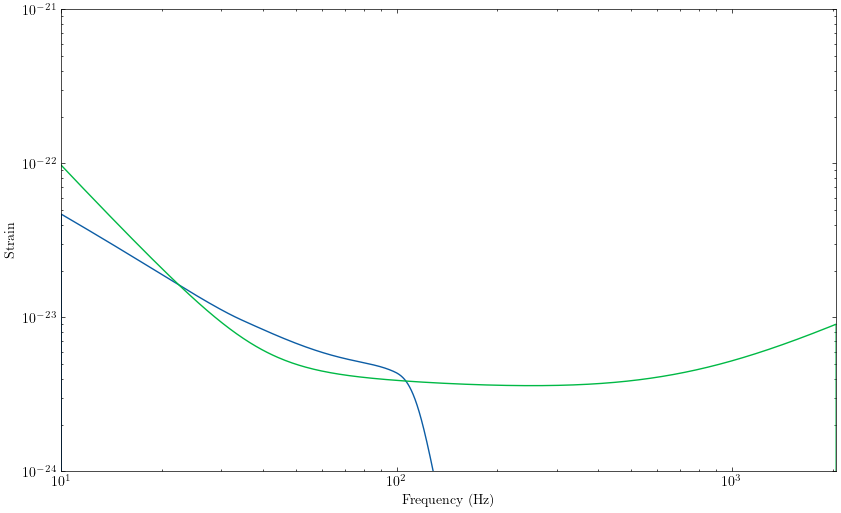

In [6]:
# # Print approximants
# print(waveform.fd_approximants())
hp_freq, hc_freq = waveform.get_fd_waveform(approximant="IMRPhenomXPHM", mass1=80, mass2=80, delta_f=1.0/16, f_lower=10, distance=2000)
# Set the hp and hc start time to the GPS time
hp_freq.start_time = hc_freq.start_time = t_gps
# Compute the plus and cross polarizations
fp, fc = detector.antenna_pattern(right_ascension, declination, polarization, t_gps)
h_freq = fp * hp_freq + fc * hc_freq
# Plot the waveform against asd
plt.plot(h_freq.sample_frequencies, np.abs(h_freq))
plt.plot(L1_psd.sample_frequencies, L1_asd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.xlim(10, 2048)
plt.ylim([1e-24, 1e-21])
plt.xscale('log')
plt.yscale('log')
plt.show()

# Plot the whitened waveform in frequency domain

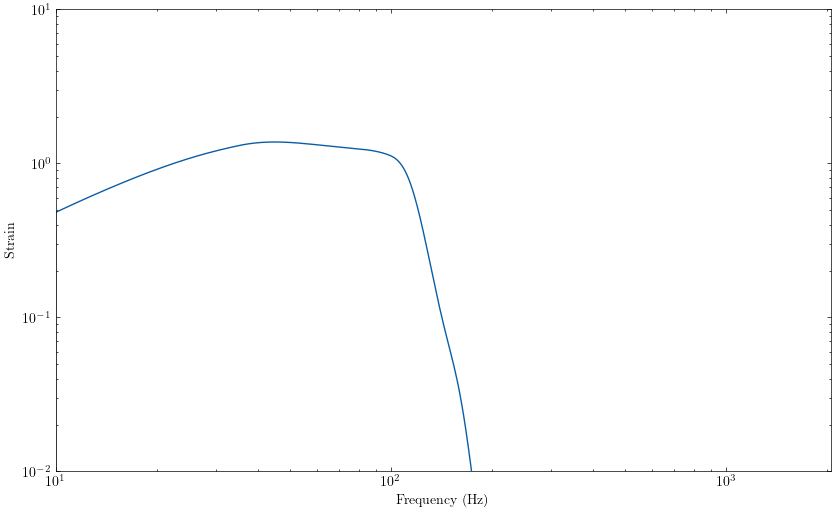

In [7]:
# Create PSD
length = len(h_freq)
delta_f = hp_freq.delta_f
low_freq_cutoff = hp_freq.sample_frequencies[0]
L1_psd = psd.aLIGOZeroDetHighPower(length, delta_f, low_freq_cutoff)
L1_asd = np.sqrt(L1_psd)
h_freq_whitened = h_freq / L1_asd
# Plot the whitened waveform
plt.plot(h_freq.sample_frequencies, np.abs(h_freq_whitened))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.xlim(10, 2048)
plt.ylim([1e-2, 10])
plt.xscale('log')
plt.yscale('log')
plt.show()

# b) Lensed waveform with change to inclination/phase of coalescence (1 image)

In [8]:
# from waveform_generation import create_whitened_waveform
import waveform_generation
from importlib import reload
reload(waveform_generation)
import lensed_parameter_transformations
reload(lensed_parameter_transformations)


<module 'lensed_parameter_transformations' from '/home/user/git/staff_projects/Paul_projects/gw-fish-lens/misc/lensed_parameter_transformations/__init__.py'>

In [12]:
def plot_phase_inc_shift( phase, inclination, phase2, inclination2, mass1=80, mass2=10, approximant="SEOBNRv4PHM"):
    t_gps=1126259462.0
    h_whitened = waveform_generation.create_whitened_waveform(phase, inclination, t_gps=t_gps, mass1 = mass1, mass2 = mass2, spin1y=0.2, approximant=approximant)
    h_whitened2 = waveform_generation.create_whitened_waveform(phase2, inclination2, t_gps=t_gps, mass1 = mass1, mass2 = mass2, spin1x=0.2, approximant=approximant)
    # Plot the waveform
    plt.plot(h_whitened.sample_times, h_whitened/np.sqrt(np.sum(h_whitened.data**2)), lw=1) # Nornalized
    plt.plot(h_whitened2.sample_times, h_whitened2/np.sqrt(np.sum(h_whitened2.data**2)), lw=1) # Normalized
    # plt.plot(h_whitened.sample_times, h_whitened/(np.max(h_whitened.data)), lw=0.1) # Maximized
    # plt.plot(h_whitened2.sample_times, h_whitened2/np.max(h_whitened2.data), lw=0.1) # Maximized
    plt.xlabel('Time (s)')
    plt.ylabel('Strain')
    plt.xlim(h_whitened.sample_times[-1]-1, h_whitened.sample_times[-1])

## Case 1:

There is maximal inclination shift:

$$\iota = \pi/2+\delta \iota$$

$$\Phi_L = \pi$$

1.5607963267948965 1.7352963267948964 -0.17449999999999988 0.1745
1.5707963267948966 1.5707963267948988


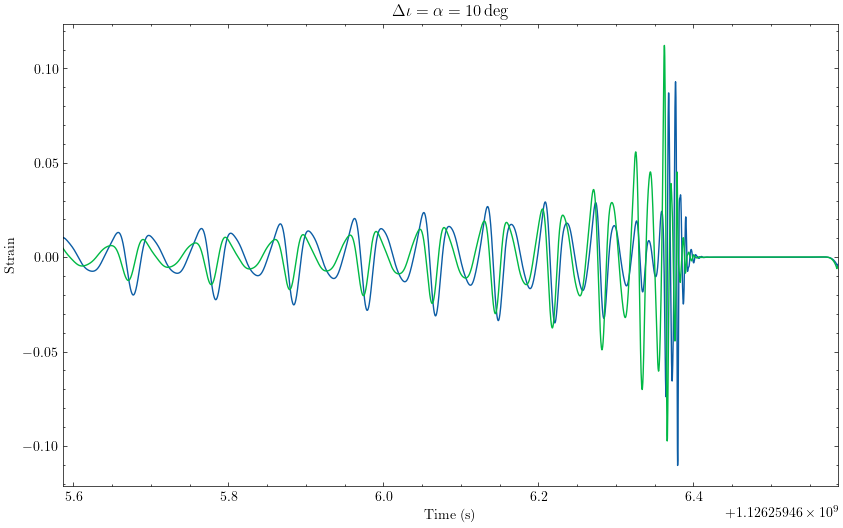

In [13]:
def incl_minus(incl, PhiL, alphaHatMinus, thetaMinus=0, beta=0):
    return np.arccos(np.cos(incl) * (np.cos((alphaHatMinus + (-beta) + (-thetaMinus))) + (np.cos(PhiL) * np.sin(incl) * (((np.cos(incl)**2) + ((np.sin(incl)**2) * (np.sin(PhiL)**2)))**(-1/2)) * np.sin((alphaHatMinus + (-beta) + (-thetaMinus))))))
def phi_coal_minus(phiCoal, incl, PhiL, alphaHatMinus, thetaMinus=0, beta=0):
    return np.arccos((np.cos(phiCoal) * ((np.cos((alphaHatMinus + (-beta) + (-thetaMinus))) * np.sin(incl)) + (-((np.cos(incl)**2) * np.cos(PhiL) * (((np.cos(incl)**2) + ((np.sin(incl)**2) * (np.sin(PhiL)**2)))**(-1/2)) * np.sin((alphaHatMinus + (-beta) + (-thetaMinus)))))) * ((((np.sin(PhiL)**2) * (1/((np.cos(incl)**2) + ((np.sin(incl)**2) * (np.sin(PhiL)**2)))) * (np.sin((alphaHatMinus + (-beta) + (-thetaMinus)))**2)) + (((np.cos((alphaHatMinus + (-beta) + (-thetaMinus))) * np.sin(incl)) + (-((np.cos(incl)**2) * np.cos(PhiL) * (((np.cos(incl)**2) + ((np.sin(incl)**2) * (np.sin(PhiL)**2)))**(-1/2)) * np.sin((alphaHatMinus + (-beta) + (-thetaMinus))))))**2))**(-1/2))) + (-(np.sin(phiCoal) * np.sin(PhiL) * np.sin((alphaHatMinus + (-beta) + (-thetaMinus))) * ((((np.cos(incl)**2) + ((np.sin(incl)**2) * (np.sin(PhiL)**2))) * (((np.sin(PhiL)**2) * (1/((np.cos(incl)**2) + ((np.sin(incl)**2) * (np.sin(PhiL)**2)))) * (np.sin((alphaHatMinus + (-beta) + (-thetaMinus)))**2)) + (((np.cos((alphaHatMinus + (-beta) + (-thetaMinus))) * np.sin(incl)) + (-((np.cos(incl)**2) * np.cos(PhiL) * (((np.cos(incl)**2) + ((np.sin(incl)**2) * (np.sin(PhiL)**2)))**(-1/2)) * np.sin((alphaHatMinus + (-beta) + (-thetaMinus))))))**2)))**(-1/2)))))
q = 0.2
mass1=80; mass2=mass1*q
phase, inclination = np.pi/2, np.pi/2-0.01
# phase2, inclination2 = np.pi/2, np.pi/4
alpha = 0.1745 # ~10 degrees 
PhiL = np.pi
inc_minus = incl_minus(inclination, PhiL, alphaHatMinus=alpha, thetaMinus=0, beta=0)
phi_minus = phi_coal_minus(phase, inclination, PhiL, alphaHatMinus=alpha, thetaMinus=0, beta=0)
print(inclination, inc_minus, inclination-inc_minus, alpha)
print(phase, phi_minus)
phase2, inclination2 = phi_minus, inc_minus
# phase2, inclination2 = phase, inc_minus
plot_phase_inc_shift(phase, inclination, phase2, inclination2, mass1=mass1, mass2=mass2)#, approximant="NRHybSur3dq8")
plt.title(r"$\Delta \iota = \alpha=10 \, \text{deg}$")
plt.show()

## Case 2:

There is maximal phase shift:

$$\iota = \pi/2$$

$$\Phi_L = \pi + \delta \Phi_L$$

1.5707963267948966 1.5707963267949072 -1.0658141036401503e-14 0.1745
1.5707963267948966 1.7452963267948967


/home/user/miniforge3/lib/python3.10/site-packages/pycbc/types/array.py:383: RuntimeWarning: divide by zero encountered in divide
  return self._data / other
/home/user/miniforge3/lib/python3.10/site-packages/pycbc/types/array.py:383: RuntimeWarning: invalid value encountered in divide
  return self._data / other


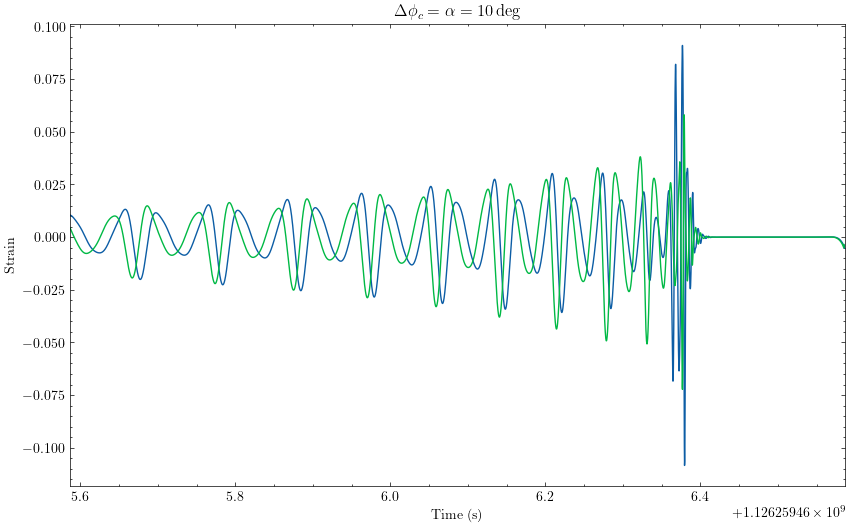

In [15]:
q = 0.2
mass1=80; mass2=mass1*q
phase, inclination = np.pi/2, np.pi/2.
# phase2, inclination2 = np.pi/2, np.pi/4
alpha = 0.1745 # ~10 degrees 
PhiL = np.pi-0.001
inc_minus = incl_minus(inclination, PhiL, alphaHatMinus=alpha, thetaMinus=0, beta=0)
phi_minus = phi_coal_minus(phase, inclination, PhiL, alphaHatMinus=alpha, thetaMinus=0, beta=0)
print(inclination, inc_minus, inclination-inc_minus, alpha)
print(phase, phi_minus)
phase2, inclination2 = phi_minus, inc_minus
# phase2, inclination2 = phase, inc_minus
plot_phase_inc_shift(phase, inclination, phase2, inclination2, mass1=mass1, mass2=mass2)#, approximant="NRHybSur3dq8")
plt.title(r"$\Delta \phi_c = \alpha=10 \, \text{deg}$")
plt.show()

Trials with other (constant) shifts of phase/inc

/home/user/miniforge3/lib/python3.10/site-packages/pycbc/types/array.py:383: RuntimeWarning: divide by zero encountered in divide
  return self._data / other
/home/user/miniforge3/lib/python3.10/site-packages/pycbc/types/array.py:383: RuntimeWarning: invalid value encountered in divide
  return self._data / other


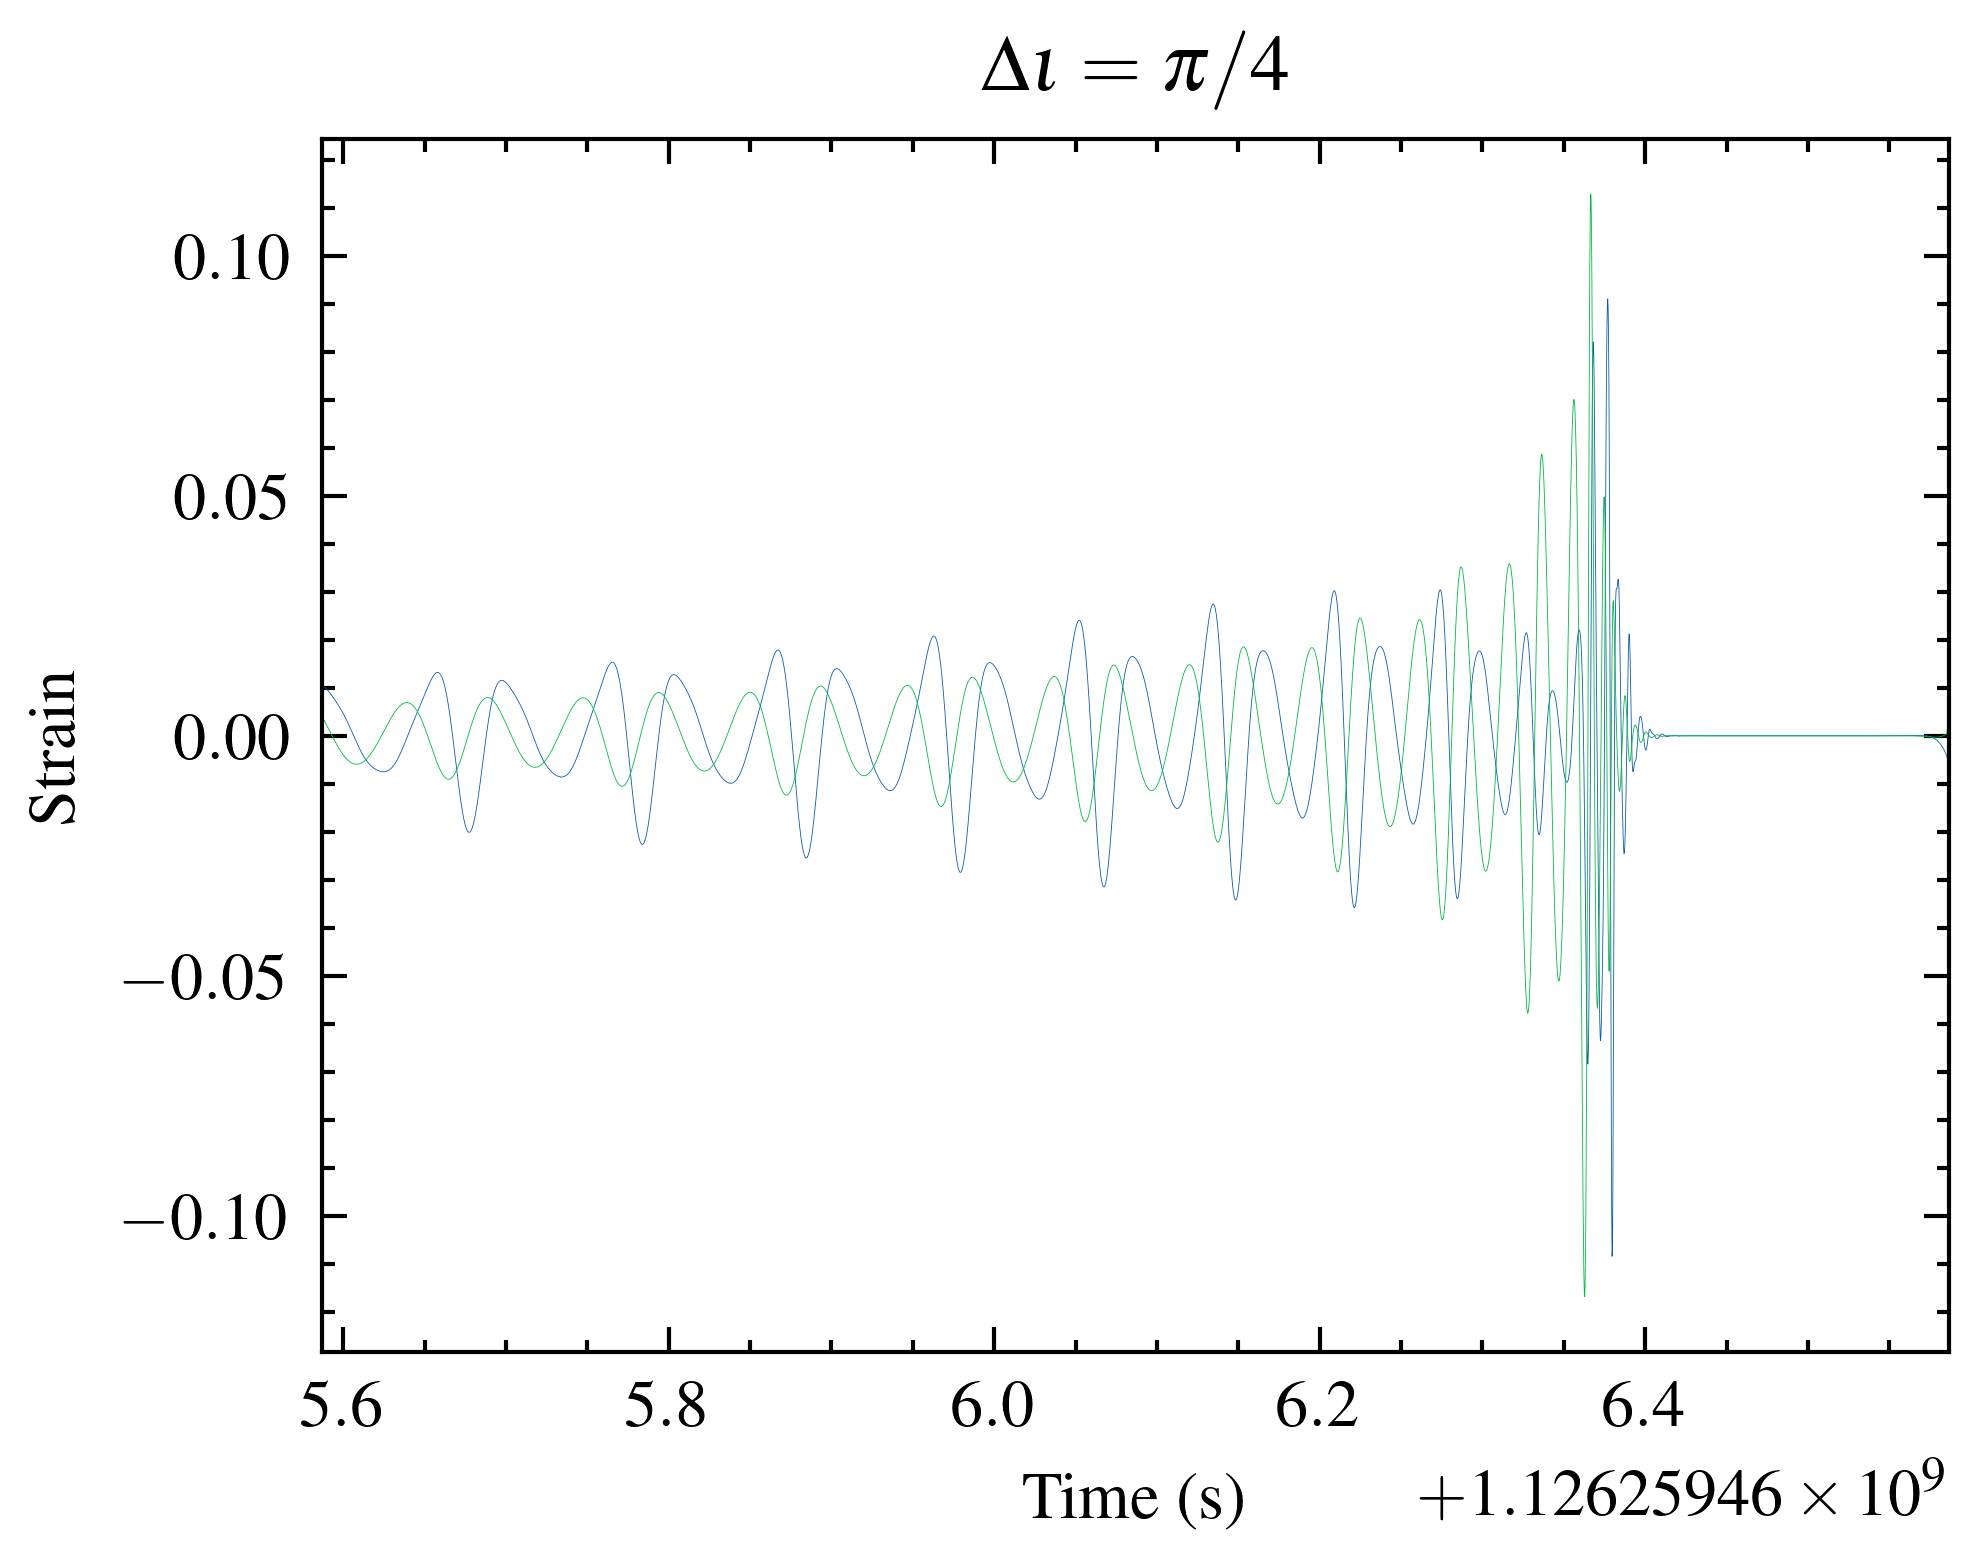

In [ ]:
q = 0.2
mass1=80; mass2=mass1*q
phase, inclination = np.pi/2, np.pi/2
phase2, inclination2 = np.pi/2, np.pi/4
plot_phase_inc_shift(phase, inclination, phase2, inclination2, mass1=mass1, mass2=mass2)#, approximant="NRHybSur3dq8")
plt.title(r"$\Delta \iota = \pi/4$")
plt.show()

Text(0.5, 1.0, '$\\Delta \\phi = \\pi/4$')

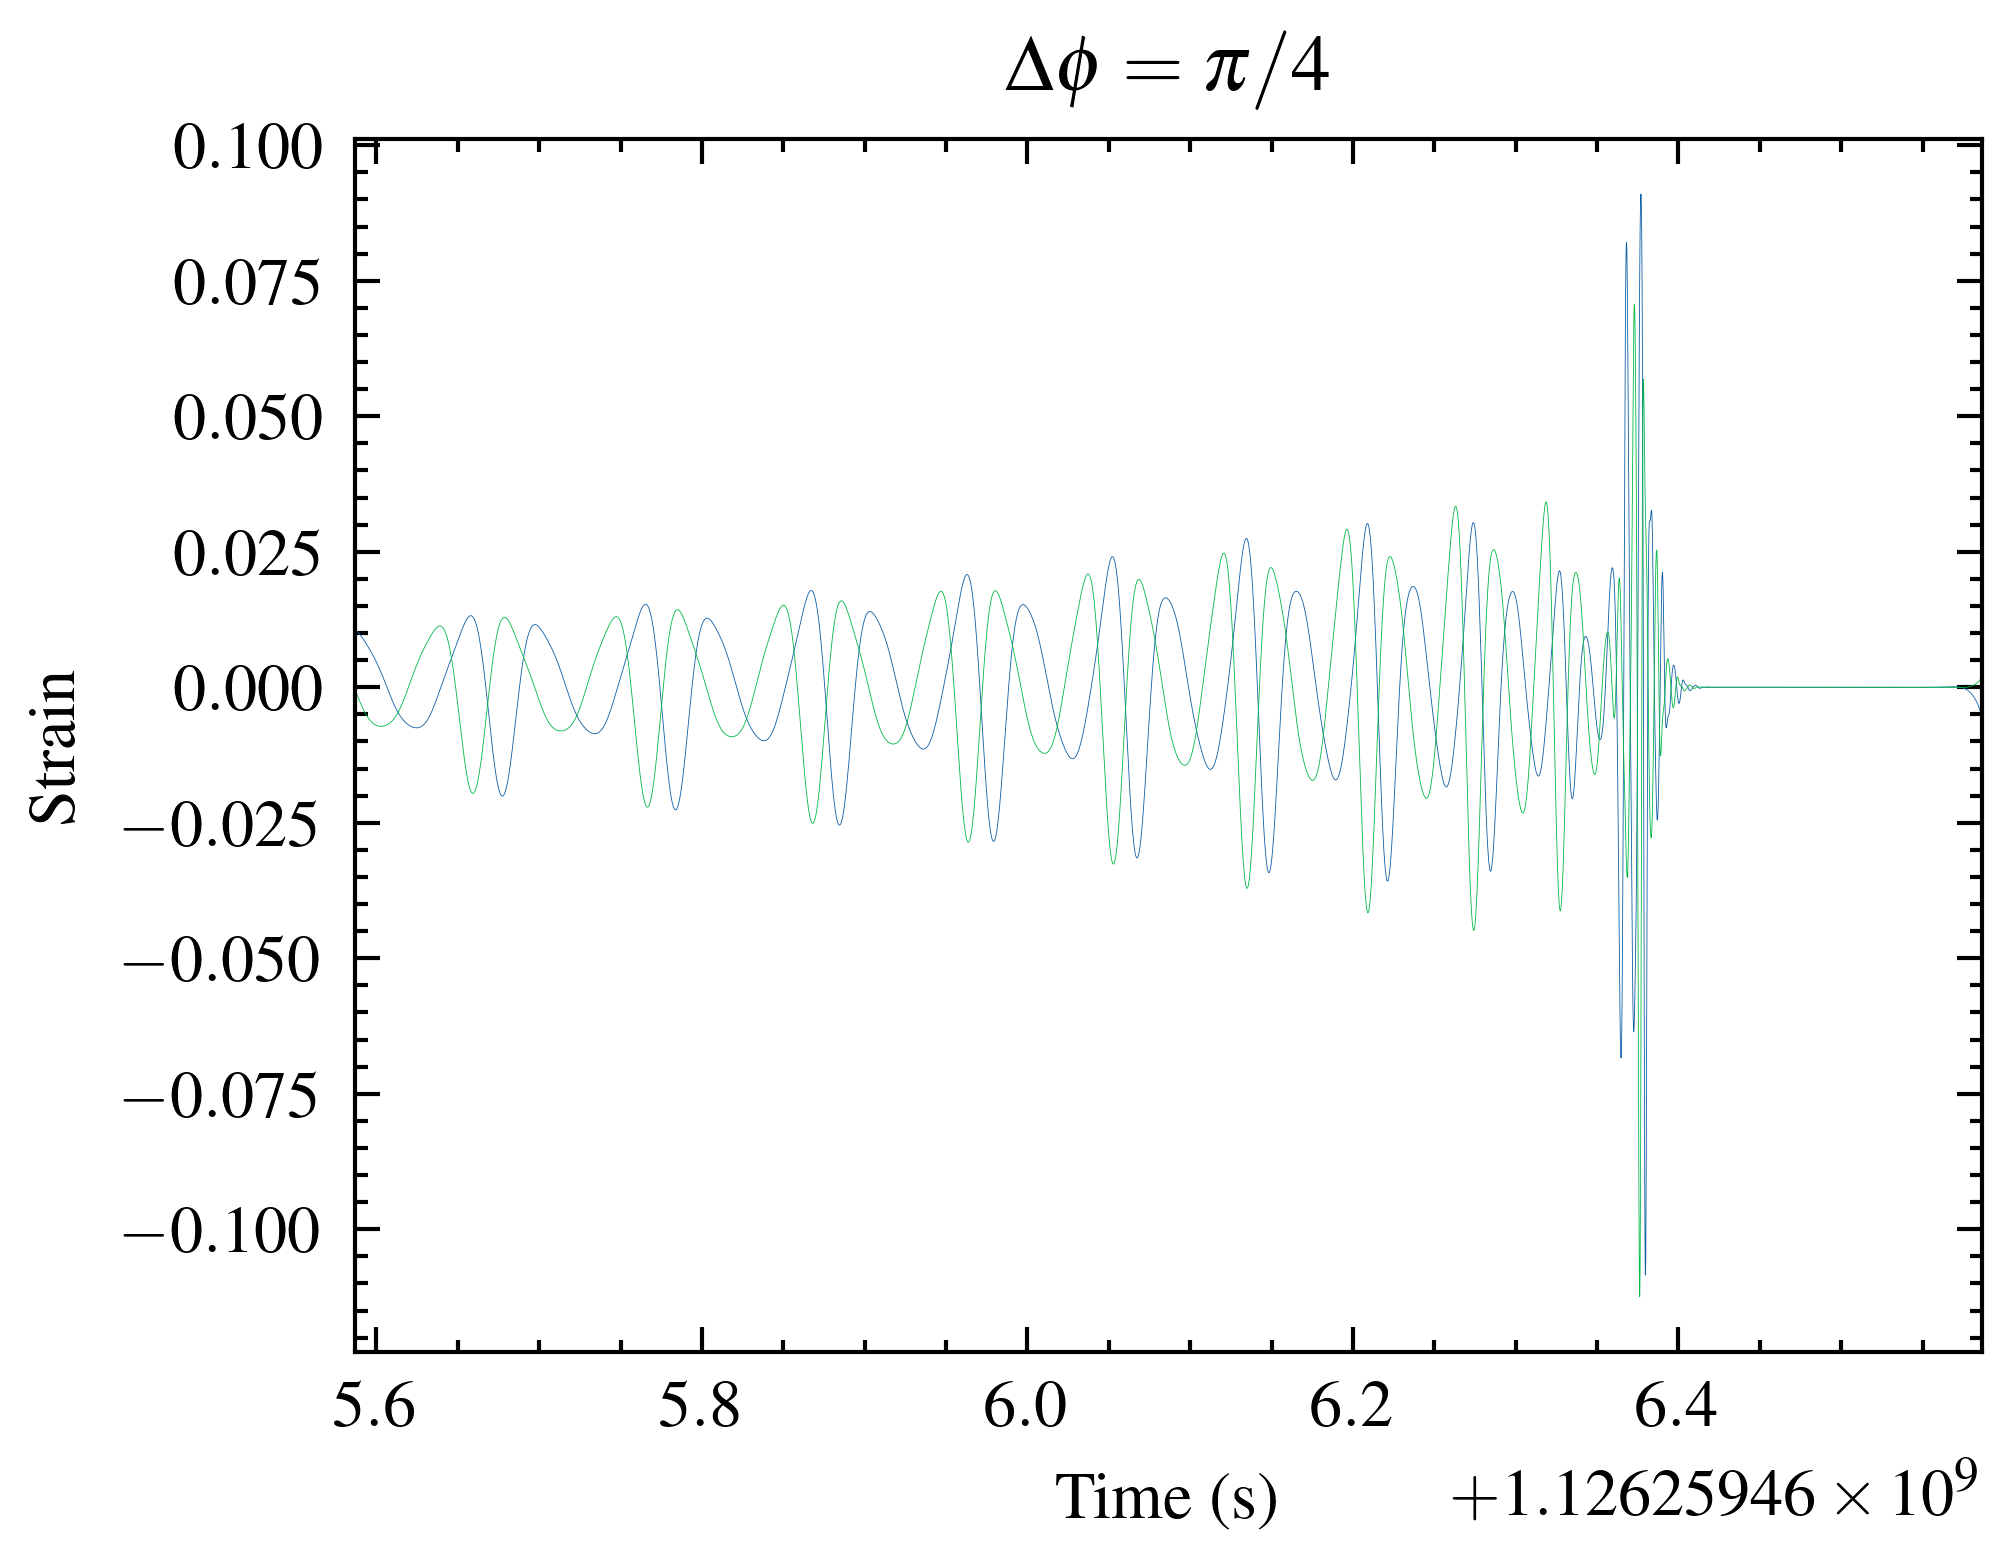

In [ ]:
phase2, inclination2 = phase+np.pi/4, np.pi/2
plot_phase_inc_shift(phase, inclination, phase2, inclination2, mass1=mass1, mass2=mass2)
plt.title(r"$\Delta \phi = \pi/4$")

In [ ]:
print("Surrogate wavefomrs:", [wf for wf in waveform.td_approximants() if "Sur" in wf])
print("Higher-order mode waveforms with precession:", [wf for wf in waveform.td_approximants() if "PHM" in wf])
print("Surrogate wavefomrs (FD):", [wf for wf in waveform.fd_approximants() if "Sur" in wf])
print("Higher-order mode waveforms with precession (FD):", [wf for wf in waveform.fd_approximants() if "PHM" in wf])
print("Higher-order mode waveforms (FD):", [wf for wf in waveform.fd_approximants() if "HM" in wf])

Surrogate wavefomrs: ['NRSur7dq2', 'NRSur7dq4', 'NRHybSur3dq8']
Higher-order mode waveforms with precession: ['SEOBNRv4PHM', 'IMRPhenomXPHM', 'IMRPhenomTPHM']
Surrogate wavefomrs (FD): ['NRSur4d2s']
Higher-order mode waveforms with precession (FD): ['IMRPhenomXPHM', 'IMRPhenomXPHM_INTERP']
Higher-order mode waveforms (FD): ['EOBNRv2HM_ROM', 'SEOBNRv4HM_ROM', 'IMRPhenomHM', 'IMRPhenomXHM', 'IMRPhenomPv3HM', 'IMRPhenomXPHM', 'SEOBNRv5HM_ROM', 'EOBNRv2HM_ROM_INTERP', 'SEOBNRv4HM_ROM_INTERP', 'IMRPhenomHM_INTERP', 'IMRPhenomPv3HM_INTERP', 'IMRPhenomXHM_INTERP', 'IMRPhenomXPHM_INTERP']
